In [1]:
from IPython.display import display
import os
import random

import torch

import torch.nn.functional as F
from torch import nn
from torch import optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torchvision.utils import make_grid
from PIL import Image

torch.set_printoptions(sci_mode=False)
torch.set_default_tensor_type('torch.FloatTensor')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
class SignsDataset(Dataset):
    def __init__(self, base_dir, split_name='train', transform=None):
        path = os.path.join(base_dir, '{}_signs'.format(split_name))
        files = os.listdir(path)

        self.filenames = [os.path.join(path, file) for file in files if file.endswith('.jpg')]
        self.targets = [int(file[0]) for file in files]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self,index):
        image = Image.open(self.filenames[index])

        if self.transform:
            image = self.transform(image)

        return image, self.targets[index]

In [3]:
class SIGNSDataset(Dataset):
  def __init__(self, base_dir, split="train", transform=None):
    path = os.path.join(base_dir, "{}_signs".format(split))
    files = os.listdir(path)
    
    self.filenames = [os.path.join(path,f) for f in files if f.endswith(".jpg")]
    
    self.targets = [int(f[0]) for f in files]
    self.transform = transform
    
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self,idx):
    image = Image.open(self.filenames[idx])
    if self.transform:
      image = self.transform(image)
    return image, self.targets[idx]

In [4]:
transform = transforms.Compose(
  [transforms.RandomHorizontalFlip(), #data augmentation
   transforms.ToTensor(),
   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))    
  ]
)

In [5]:
trainset = SignsDataset('../datasets/64x64_SIGNS', 'train', transform)
trainloader = DataLoader(dataset=trainset, batch_size=32, shuffle=True)

valset = SignsDataset('../datasets/64x64_SIGNS', 'val', transform)
valloader = DataLoader(valset, 32, True)

testset = SignsDataset('../datasets/64x64_SIGNS', 'test', transform)
testloader = DataLoader(testset, 32)

dataloaders = { 'train' : trainloader,
                'test' : testloader,
                'val' : valloader
                }

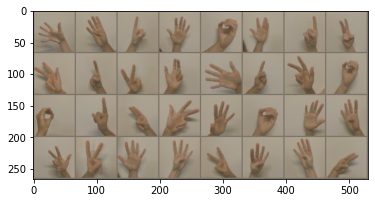

tensor([5, 4, 1, 5, 0, 5, 1, 2, 3, 1, 2, 3, 5, 1, 3, 0, 0, 1, 2, 3, 5, 0, 5, 4,
        3, 2, 5, 4, 2, 4, 4, 2])


In [6]:
from torchvision.utils import make_grid
import sys
sys.path.append('..')
from plot_helpers import imshow


for inputs, targets in dataloaders['train']:
    out = make_grid(inputs)
    imshow(out)
    print(targets)
    break

In [7]:
class Model(nn.Module):
    def __init__(self, n_channels):
        super(Model, self).__init__()

        self.n_channels = n_channels

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.n_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.n_channels)

        self.conv2 = nn.Conv2d(self.n_channels, self.n_channels*2, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.n_channels*2)

        self.conv3 = nn.Conv2d(self.n_channels*2, self.n_channels*4, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.n_channels*4)

        self.fc1 = nn.Linear(self.n_channels*4*8*8, self.n_channels*4)
        self.fcbn1 = nn.BatchNorm1d(self.n_channels*4)

        self.fc2 = nn.Linear(self.n_channels*4, 6)


    def forward(self, x):
        x = self.bn1( self.conv1(x) )
        x = F.relu( F.max_pool2d(x, 2) )

        x = self.bn2( self.conv2(x) )
        x = F.relu( F.max_pool2d(x, 2) )
        
        x = self.bn3( self.conv3(x) )
        x = F.relu( F.max_pool2d(x, 2) )

        x = x.view(-1, self.n_channels*4*8*8)

        x = F.relu( self.fcbn1( self.fc1(x) ) )
        x = F.dropout(x, p=0.8, training=True)
        x = self.fc2(x)

        x = F.log_softmax(x, dim=1)

        return x

In [8]:
class RunningMetric():
    def __init__(self):
        self.data = 0
        self.n_data = 0

    def update(self, val, size):
        self.data += val
        self.n_data += size

    def __call__(self):
        return self.data/float(self.n_data)
        

In [9]:
def train_and_evaluate(model, optimizer, loss_fn, dataloaders, device, n_epochs=10, lr=0.001):
    for g in optimizer.param_groups:
        g['lr'] = lr

    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1} / {n_epochs} \n', '_'*15)

        for phase in ['train', 'val']:
            train = True if phase == 'train' else False
            
            model.train() if train else model.eval()

            running_loss = RunningMetric() 
            running_acc = RunningMetric()

            for inputs, targets in dataloaders[phase]:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(train):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = loss_fn(outputs, targets)
                    if train:
                        loss.backward()
                        optimizer.step()

                batch_size = inputs.shape[0]
                running_loss.update(loss.item()*batch_size, batch_size)
                running_acc.update(torch.sum(predictions == targets).float(), batch_size)

            print(phase)
            print('Loss:  {:.4f}     Acc:  {:.3%}\n'.format(running_loss(), running_acc()))

    return model

In [10]:
model = Model(32).to(device)
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9)
lrs = [10**(-random.randint(3,7) ) for _ in range(3)]

In [11]:
for lr in lrs:
    print(f'----- LEARNING RATE:   {lr} -----\n')
    train_and_evaluate(model, optimizer, loss_fn, dataloaders, device, 10, lr)

----- LEARNING RATE:   0.001 -----

Epoch 1 / 10 
 _______________
train
Loss:  1.6013     Acc:  37.963%

val
Loss:  1.9388     Acc:  28.704%

Epoch 2 / 10 
 _______________
train
Loss:  1.2247     Acc:  55.671%

val
Loss:  1.1741     Acc:  58.333%

Epoch 3 / 10 
 _______________
train
Loss:  1.0106     Acc:  64.931%

val
Loss:  0.9521     Acc:  68.981%

Epoch 4 / 10 
 _______________
train
Loss:  0.9340     Acc:  68.287%

val
Loss:  0.8406     Acc:  70.370%

Epoch 5 / 10 
 _______________
train
Loss:  0.8137     Acc:  73.843%

val
Loss:  0.8466     Acc:  74.537%

Epoch 6 / 10 
 _______________
train
Loss:  0.7407     Acc:  76.852%

val
Loss:  0.7090     Acc:  74.074%

Epoch 7 / 10 
 _______________
train
Loss:  0.6770     Acc:  78.819%

val
Loss:  0.6751     Acc:  78.704%

Epoch 8 / 10 
 _______________
train
Loss:  0.6117     Acc:  81.597%

val
Loss:  0.6425     Acc:  81.019%

Epoch 9 / 10 
 _______________
train
Loss:  0.5931     Acc:  83.796%

val
Loss:  0.6597     Acc:  75.463%

E

In [12]:
running_loss = RunningMetric() 
running_acc = RunningMetric()

for inputs, targets in dataloaders['test']:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    loss = loss_fn(outputs, targets)

    batch_size = inputs.shape[0]
    running_loss.update(loss.item()*batch_size, batch_size)
    running_acc.update(torch.sum(predictions == targets).float(), batch_size)

print('Loss:  {:.4f}     Acc:  {:.3%}\n\n'.format(running_loss(), running_acc()))


Loss:  0.5607     Acc:  83.333%


